# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [30]:
# pip install phik catboost shap optuna

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import optuna

import warnings; warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [3]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
345,m17609944Y,Hyundai Solaris,economy,petrol,2.98,2012,24309,2015,71.73,another_bug
1216,D-6990841m,Kia Sportage,standart,petrol,4.14,2013,40420,2019,35.23,break_bug
592,j-3753181u,Kia Rio X,economy,petrol,4.62,2015,77798,2018,29.98,engine_overheat
2310,b-1553102t,Renault Kaptur,standart,petrol,4.74,2015,79993,2017,64.31,engine_ignition
1830,q-1219686k,Smart ForTwo,economy,petrol,4.74,2015,88750,2017,21.98,break_bug


In [231]:
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [4]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
507347,K64449705j,j22108372p,q1A,2020-03-13,4.19,80,873,48,68.000000,1,1072.273656,0,-6.068776,-3.998
313992,N21629653v,W-2145474K,M1p,2020-02-21,1.12,36,353,69,124.762183,0,2530.960276,0,-19.163315,-0.170
61040,B13221485V,E-2189846g,j1y,2020-03-15,5.09,23,291,36,65.000000,2,78.249827,0,-24.005051,15.998
305441,T21476383C,V16180698h,K1z,2020-02-08,7.54,41,444,38,51.000000,2,482.657251,0,6.706560,-2.322
458110,F10525768e,g-5564720R,a1c,2020-03-16,5.46,13,164,37,62.000000,1,481.567745,0,0.295638,-58.490


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [5]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
8810,42,8.6,1148,12.0,O45438519u,0,2021-3-8
9739,44,8.2,404,2.0,w82931469Z,0,2020-5-26
10859,35,9.3,78,19.0,i34450975W,1,2019-12-7
549,33,8.9,1296,9.0,e63271509q,1,2018-9-12
12041,46,7.4,659,2.0,p20412174x,0,2019-5-23


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [6]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
71739,s-9164758n,HS,2019-3-29 7:46,refuel,1.0,22
97503,R23868498r,IP,2020-8-22 15:38,repair,6.6,24
106287,P68488505Z,SG,2019-7-29 20:0,reparking,1.0,28
29224,m-6830168g,OJ,2020-2-10 8:1,repair,5.0,14
134965,O13331241u,EO,2019-12-19 16:56,reparking,1.0,29


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

In [7]:
rides_info['ride_date'] = pd.to_datetime(rides_info['ride_date'])
rides_info = rides_info.sort_values(by='ride_date')

In [8]:
def av_trend(column):
    return column.diff().sum()

rides_info_gp = rides_info.groupby('car_id').agg(
    ride_count = ('ride_id', 'count'), # есть в общей таблице за более длительный период
    first_ride = ('ride_date', 'min'),
    last_ride = ('ride_date', 'max'),
    av_rating = ('rating', 'mean'), # есть в общей таблице за более длительный период
    min_rating = ('rating', 'min'),
    av_rating_trend = ('rating', av_trend),
    av_ride_duration =  ('ride_duration', 'mean'),
    sum_ride_duration =  ('ride_duration', 'sum'),
    av_speed_avg =  ('speed_avg', 'mean'),
    av_speed_avg_trend =  ('speed_avg', av_trend),
    max_speed = ('speed_max', 'max'),
    av_stop_times =  ('stop_times', 'mean'),
    av_distance =  ('distance', 'mean'),
    sum_distance =  ('distance', 'sum'),
    sum_refueling =  ('refueling', 'sum'),
    av_user_ride_quality =  ('user_ride_quality', 'mean'),
    av_deviation_normal =  ('deviation_normal', 'mean'),
).reset_index()

rides_info_gp['fuel_consump'] = rides_info_gp['sum_distance'] / rides_info_gp['sum_refueling']
rides_info_gp['last_ride'] = pd.to_datetime(rides_info_gp['last_ride'])
rides_info_gp['first_ride'] = pd.to_datetime(rides_info_gp['first_ride'])
rides_info_gp['period'] = rides_info_gp['last_ride'] - rides_info_gp['first_ride']
rides_info_gp['frequency'] = rides_info_gp['period'] / rides_info_gp['ride_count']

In [9]:
rides_info_gp.sample()

,car_id,ride_count,first_ride,last_ride,av_rating,min_rating,av_rating_trend,av_ride_duration,sum_ride_duration,av_speed_avg,av_speed_avg_trend,max_speed,av_stop_times,av_distance,sum_distance,sum_refueling,av_user_ride_quality,av_deviation_normal,fuel_consump,period,frequency
1569,T-1009246T,174,2020-01-01,2020-04-01,4.454368,0.1,-1.63,2577.425287,448472,44.551724,-11.0,112.021331,0.775862,117484.458459,2.044230e+07,0,-6.591333,-6.692161,inf,91 days,0 days 12:33:06.206896551


In [10]:
# Часть фичей оказалась очевидно бесполезной, их не будем присоединять
rides_info_gp.nunique()

car_id                  4250
ride_count                 1
first_ride                 1
last_ride                  2
av_rating               3892
min_rating               107
av_rating_trend         3993
av_ride_duration        4211
sum_ride_duration       4211
av_speed_avg            1290
av_speed_avg_trend       118
max_speed               3495
av_stop_times            314
av_distance             4250
sum_distance            4250
sum_refueling              2
av_user_ride_quality    4250
av_deviation_normal     4242
fuel_consump               4
period                     2
frequency                  2
dtype: int64

In [11]:
car_train = car_train.merge(rides_info_gp[['car_id',
       'min_rating', 'av_rating_trend', 'av_ride_duration',
       'sum_ride_duration', 'av_speed_avg', 'av_speed_avg_trend', 'max_speed',
       'av_stop_times', 'av_distance', 'sum_distance',
       'av_user_ride_quality', 'av_deviation_normal']], on='car_id', how='left')

In [12]:
car_train.sample()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,av_rating_trend,av_ride_duration,sum_ride_duration,av_speed_avg,av_speed_avg_trend,max_speed,av_stop_times,av_distance,sum_distance,av_user_ride_quality,av_deviation_normal
2220,R10132699W,Smart ForTwo,economy,petrol,4.6,2017,115169,2014,42.88,wheel_shake,0.54,-0.15,2079.936782,361909,42.87931,7.0,129.755338,3.833333,90998.642782,1.583376e+07,1.704758,1.979776


In [13]:
driver_info.sample()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
5155,31,9.2,1057,19.0,v35322195l,1,2020-11-17


In [14]:
rides_info = rides_info.merge(driver_info, on='user_id', how='left')
rides_info.sample()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
728199,R19573779e,b-5677746H,F1k,2020-03-31,1.46,10193,112119,46,165.212191,1,475824.626024,0,-6.363324,-16.965,25,8.0,715,11.0,1,2020-8-18


In [15]:
driver_info_gp = rides_info.groupby('car_id').agg(
    av_rider_age = ('age', 'mean'),
    min_rider_age = ('age', 'min'),
    av_user_rating = ('user_rating', 'mean'),
    min_user_rating = ('user_rating', 'min'),
    av_user_rides = ('user_rides', 'mean'),
    sum_user_time_accident = ('user_time_accident', 'sum'),
    av_sex = ('sex', 'mean')
).reset_index()

In [16]:
driver_info_gp.nunique()

car_id                    4250
av_rider_age               822
min_rider_age                4
av_user_rating             919
min_user_rating             18
av_user_rides             3989
sum_user_time_accident    1216
av_sex                      58
dtype: int64

In [17]:
car_train = car_train.merge(driver_info_gp, on='car_id', how='left')

In [18]:
fix_info.sample()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
137845,b53350458l,FF,2020-10-23 13:16,refuel_check,1.0,33


In [19]:
fix_info_gp = fix_info.groupby('car_id').agg(
    repair_count = ('fix_date', 'count'),
    sum_destroy_degree = ('destroy_degree', 'sum'),
    sum_work_duration = ('work_duration', 'sum'),
)

In [20]:
car_train = car_train.merge(fix_info_gp, on='car_id', how='left')

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [21]:
# неуникальных нет
car_train.nunique()[car_train.nunique() < 2]

Series([], dtype: int64)

In [22]:
# удаляем ключи
car_train.drop(columns='car_id', inplace=True)

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'av_rating_trend', 'av_ride_duration', 'sum_ride_duration', 'av_speed_avg', 'av_speed_avg_trend', 'max_speed', 'av_stop_times', 'av_distance', 'sum_distance', 'av_user_ride_quality', 'av_deviation_normal', 'av_rider_age', 'min_rider_age', 'av_user_rating', 'min_user_rating', 'av_user_rides', 'sum_user_time_accident', 'av_sex', 'repair_count', 'sum_destroy_degree', 'sum_work_duration']


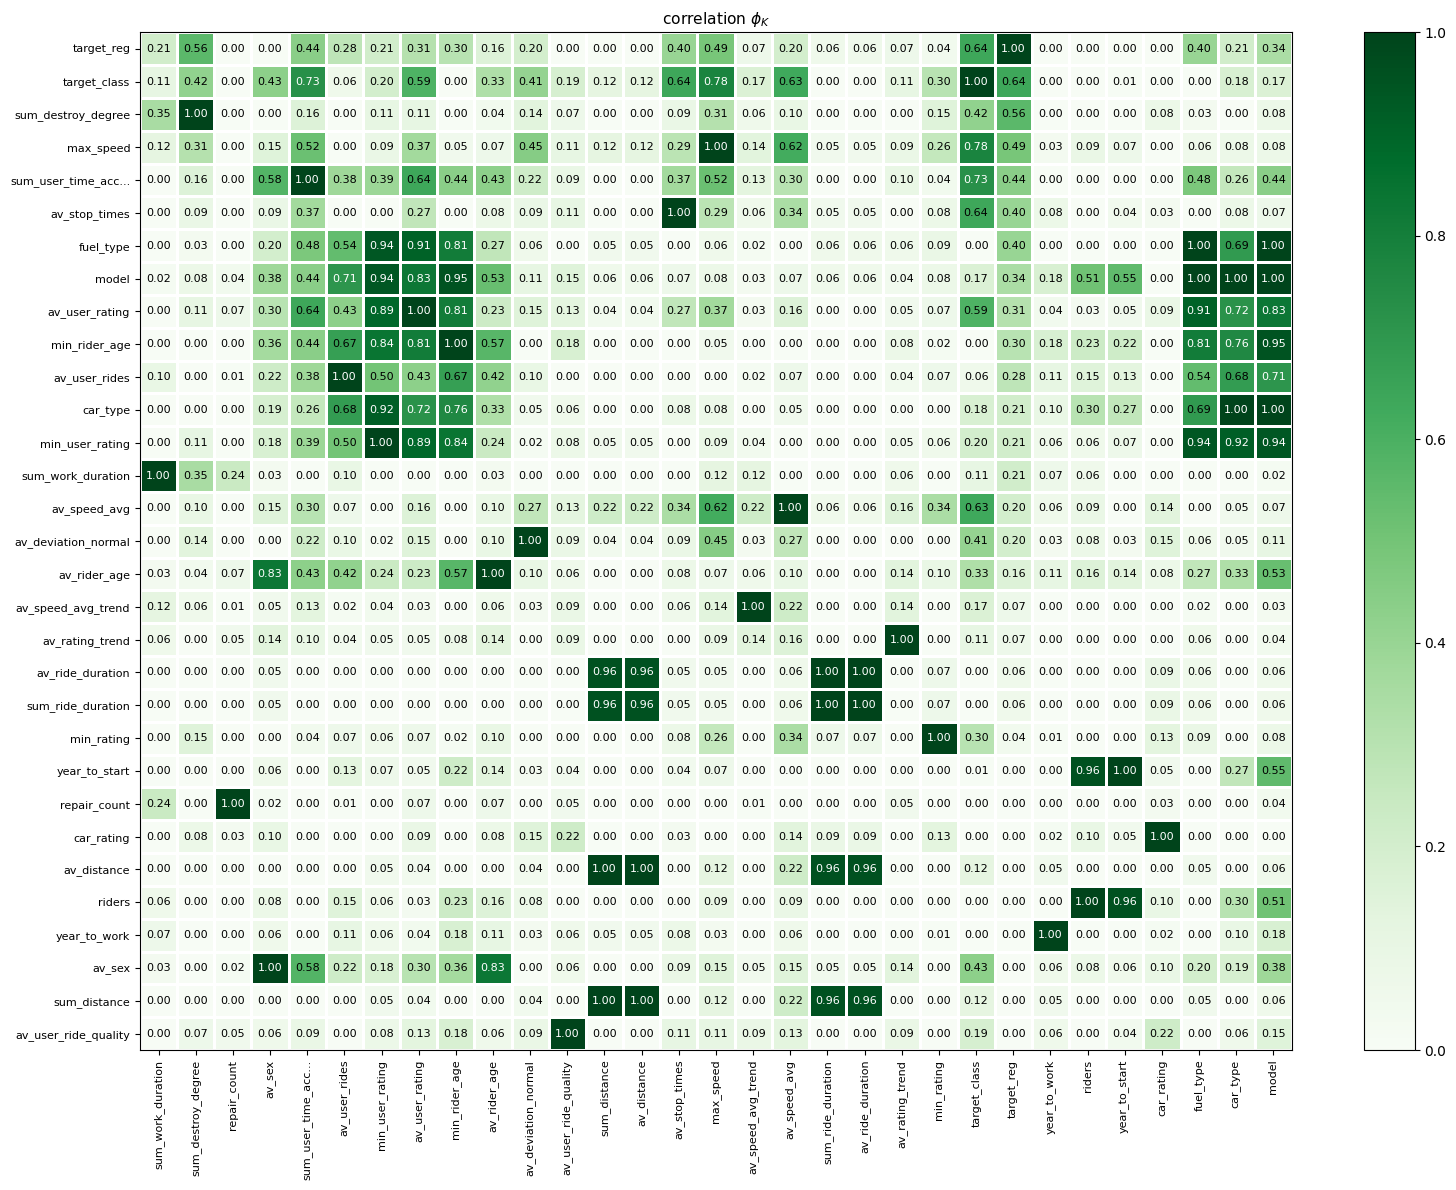

In [31]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = car_train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(16, 12))
plt.tight_layout()

In [51]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

drop_cols = ['target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model']

X = car_train.drop(drop_cols, axis=1, errors = 'ignore')
y = car_train['target_class'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,
                           task_type='GPU')
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.112012
0:	learn: 1.5386094	test: 1.5490997	best: 1.5490997 (0)	total: 11.3ms	remaining: 11.3s
100:	learn: 0.0329249	test: 0.0579863	best: 0.0579863 (100)	total: 976ms	remaining: 8.69s
200:	learn: 0.0181474	test: 0.0491918	best: 0.0491918 (200)	total: 1.95s	remaining: 7.74s
300:	learn: 0.0113757	test: 0.0445226	best: 0.0444900 (299)	total: 2.89s	remaining: 6.71s
400:	learn: 0.0080084	test: 0.0420750	best: 0.0420731 (398)	total: 3.85s	remaining: 5.75s
500:	learn: 0.0061876	test: 0.0415396	best: 0.0413336 (478)	total: 4.83s	remaining: 4.81s
600:	learn: 0.0050139	test: 0.0413547	best: 0.0412162 (575)	total: 5.79s	remaining: 3.84s
bestTest = 0.04121620635
bestIteration = 575
Shrink model to first 576 iterations.


In [52]:
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      1.00      1.00        49
    engine_fuel       0.98      0.97      0.97        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       0.96      0.98      0.97        48
     gear_stick       1.00      1.00      1.00        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



In [53]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[57,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0, 56,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 51,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 49,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 56,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0, 58,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 47,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 51,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0, 37]], dtype=int64)

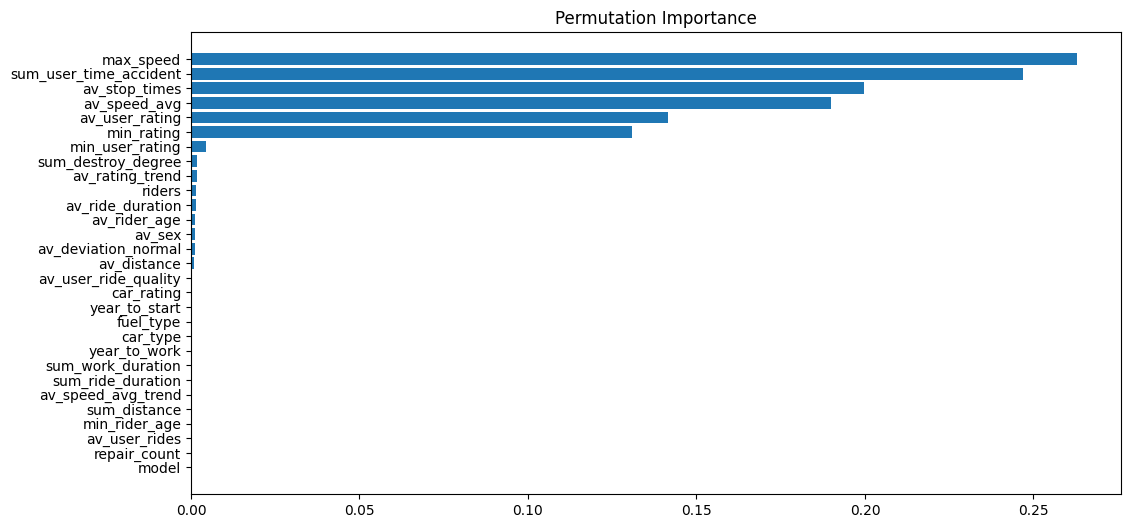

In [54]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [55]:
# Извлекаем средние значения важности признаков
feature_importances = perm_importance.importances_mean
# Определяем индексы неважных признаков (с нулевым или отрицательным значением важности)
non_important_features_indices = [idx for idx, importance in enumerate(feature_importances) if importance <= 0.0]
# Получаем названия неважных признаков
non_important_features = [X_test.columns[idx] for idx in non_important_features_indices]
print("Неважные признаки:", non_important_features)

Неважные признаки: ['model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'year_to_work', 'sum_ride_duration', 'av_speed_avg_trend', 'sum_distance', 'min_rider_age', 'av_user_rides', 'repair_count', 'sum_work_duration']


In [47]:
drop_cols = ['target_class', 'target_reg'] + non_important_features
cat_cols = [f for f in ['car_type', 'fuel_type', 'model'] if f not in non_important_features]

X = car_train.drop(drop_cols, axis=1)
y = car_train['target_class'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,
                           task_type='GPU')
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.112012
0:	learn: 1.5352815	test: 1.5432495	best: 1.5432495 (0)	total: 7.05ms	remaining: 7.04s
100:	learn: 0.0328172	test: 0.0609689	best: 0.0609689 (100)	total: 547ms	remaining: 4.87s
200:	learn: 0.0168265	test: 0.0514896	best: 0.0514896 (200)	total: 1.09s	remaining: 4.32s
300:	learn: 0.0106059	test: 0.0498525	best: 0.0497896 (299)	total: 1.63s	remaining: 3.78s
400:	learn: 0.0076334	test: 0.0495243	best: 0.0494949 (357)	total: 2.16s	remaining: 3.22s
500:	learn: 0.0058550	test: 0.0496153	best: 0.0491613 (459)	total: 2.7s	remaining: 2.69s
bestTest = 0.04916131598
bestIteration = 459
Shrink model to first 460 iterations.


In [48]:
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      1.00      1.00        49
    engine_fuel       0.98      0.97      0.97        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       0.96      0.98      0.97        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.98      0.98      0.98       468
   weighted avg       0.99      0.99      0.99       468



In [50]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[57,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0, 56,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 51,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 49,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 56,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0, 58,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 47,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 50,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0, 37]], dtype=int64)

In [56]:
summary = model.select_features(X_train, y_train,
                      eval_set=(X_test, y_test),
                      features_for_select='0-24',
                      num_features_to_select=11,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [57]:
summary

{'selected_features': [5, 7, 11, 13, 14, 18, 19, 21, 22, 23, 24],
 'eliminated_features_names': ['av_distance',
  'av_user_ride_quality',
  'car_rating',
  'av_speed_avg_trend',
  'fuel_type',
  'av_rating_trend',
  'av_ride_duration',
  'year_to_work',
  'sum_distance',
  'sum_ride_duration',
  'model',
  'car_type',
  'year_to_start',
  'min_rider_age'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  'loss_values': [0.041825334713668484,
   0.041127776144600926,
   0.040713797438550456,
   0.040358637196622256,
   0.040108121368357855,
   0.03997733913567546,
   0.03987594434902743,
   0.039813031033971734,
   0.03979949305812055,
   0.039797770643149696,
   0.03979777064314969,
   0.03979777064314969,
   0.03980522659685257,
   0.03981069735925446,
   0.03984138355650365]},
 'eliminated_features': [15, 17, 3, 12, 2, 8, 9, 6, 16, 10, 0, 1, 4, 20],
 'selected_features_names': ['riders',
  'min_rating',
  'av_speed

In [61]:
drop_cols = ['target_class', 'target_reg'] + summary['eliminated_features_names']
cat_cols = [f for f in ['car_type', 'fuel_type', 'model'] if f not in summary['eliminated_features_names']]

X = car_train.drop(drop_cols, axis=1)
y = car_train['target_class'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,
                           task_type='GPU')
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

Learning rate set to 0.112012
0:	learn: 1.5352814	test: 1.5432495	best: 1.5432495 (0)	total: 7.31ms	remaining: 7.3s
100:	learn: 0.0315393	test: 0.0562648	best: 0.0562648 (100)	total: 601ms	remaining: 5.35s
200:	learn: 0.0162669	test: 0.0467781	best: 0.0467781 (200)	total: 1.16s	remaining: 4.63s
300:	learn: 0.0102255	test: 0.0430304	best: 0.0430304 (300)	total: 1.74s	remaining: 4.04s
400:	learn: 0.0072451	test: 0.0417093	best: 0.0416922 (380)	total: 2.31s	remaining: 3.45s
500:	learn: 0.0055784	test: 0.0413996	best: 0.0412028 (478)	total: 2.87s	remaining: 2.85s
bestTest = 0.04120276524
bestIteration = 478
Shrink model to first 479 iterations.
                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      1.00      1.00        49
    engine_fuel       0.98      0.97      0.97        58
engine_i

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [25]:
features2drop = ['target_class', 'target_reg'] # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['model', 'car_type', 'fuel_type',] # категориальные признаки

num_features = [i for i in list(car_train.columns) if i not in (features2drop + targets + cat_features)] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 26 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'av_rating_trend', 'av_ride_duration', 'sum_ride_duration', 'av_speed_avg', 'av_speed_avg_trend', 'max_speed', 'av_stop_times', 'av_distance', 'sum_distance', 'av_user_ride_quality', 'av_deviation_normal', 'av_rider_age', 'min_rider_age', 'av_user_rating', 'min_user_rating', 'av_user_rides', 'sum_user_time_accident', 'av_sex', 'repair_count', 'sum_destroy_degree', 'sum_work_duration']
Целевые переменные ['target_class', 'target_reg']


In [26]:
X = car_train.drop(features2drop, axis=1)
y = car_train[targets[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_features,
                           thread_count=-1,
                           custom_metric=['Accuracy'],
                           early_stopping_rounds=100,)

In [27]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          use_best_model=True,
          task_type='GPU')

Learning rate set to 0.109335
0:	learn: 1.6284531	test: 1.6408581	best: 1.6408581 (0)	total: 41.8ms	remaining: 41.7s
100:	learn: 0.0448945	test: 0.0692943	best: 0.0692943 (100)	total: 4.82s	remaining: 42.9s
200:	learn: 0.0236228	test: 0.0527403	best: 0.0526988 (198)	total: 9.73s	remaining: 38.7s
300:	learn: 0.0148288	test: 0.0466749	best: 0.0466749 (300)	total: 14.7s	remaining: 34s
400:	learn: 0.0109800	test: 0.0445702	best: 0.0445494 (396)	total: 19.7s	remaining: 29.5s
500:	learn: 0.0085713	test: 0.0436808	best: 0.0436223 (492)	total: 24.7s	remaining: 24.6s
600:	learn: 0.0071591	test: 0.0422528	best: 0.0422440 (598)	total: 29.6s	remaining: 19.6s
700:	learn: 0.0059506	test: 0.0414928	best: 0.0413545 (668)	total: 34.3s	remaining: 14.6s
800:	learn: 0.0050667	test: 0.0414086	best: 0.0413286 (770)	total: 39.1s	remaining: 9.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04132858609
bestIteration = 770

Shrink model to first 771 iterations.


In [28]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9871794871794872


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [40]:
# Посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi[fi['Importances'] > 0.5]

,Feature Id,Importances
0,max_speed,23.083022
1,sum_user_time_accident,19.033938
2,av_user_rating,15.156951
3,av_stop_times,14.123237
4,av_speed_avg,11.722626
5,min_rating,8.332260
6,sum_destroy_degree,2.039653
7,av_sex,1.310349
8,car_type,0.801842
9,model,0.633782


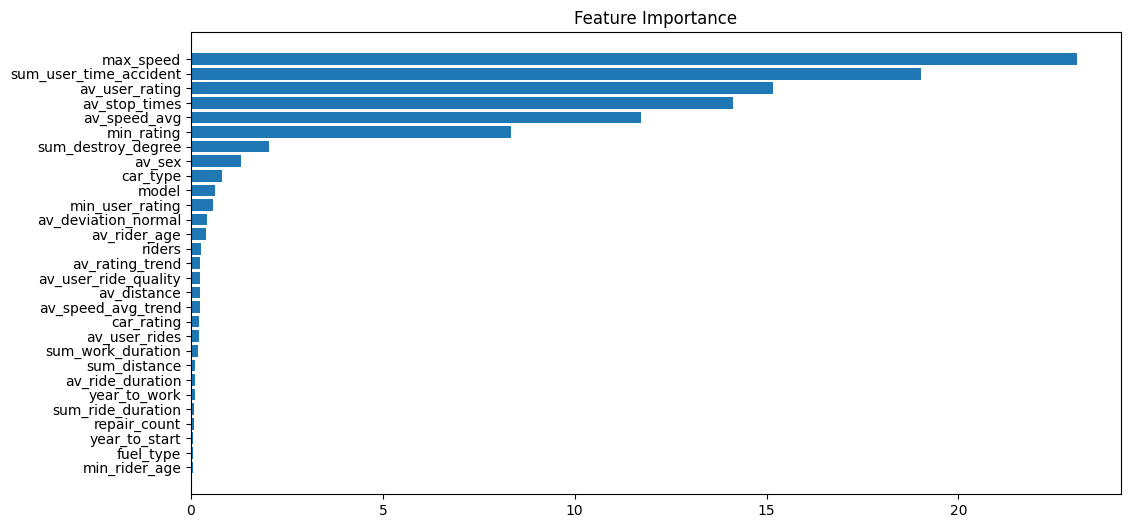

In [41]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

*На частоту ремонтов наибольшим образом влияет качество водителей и их склонность лихачить (возрост, пол и модель скорее всего тоже коррелируют с этими признаками). Также, чем больше остановок - тем больше ремонтов, эот может быть связано как с необходимостью лишний раз заводиться/прогреваться, так и с особенностями эксплуатации отдельными водителями.*

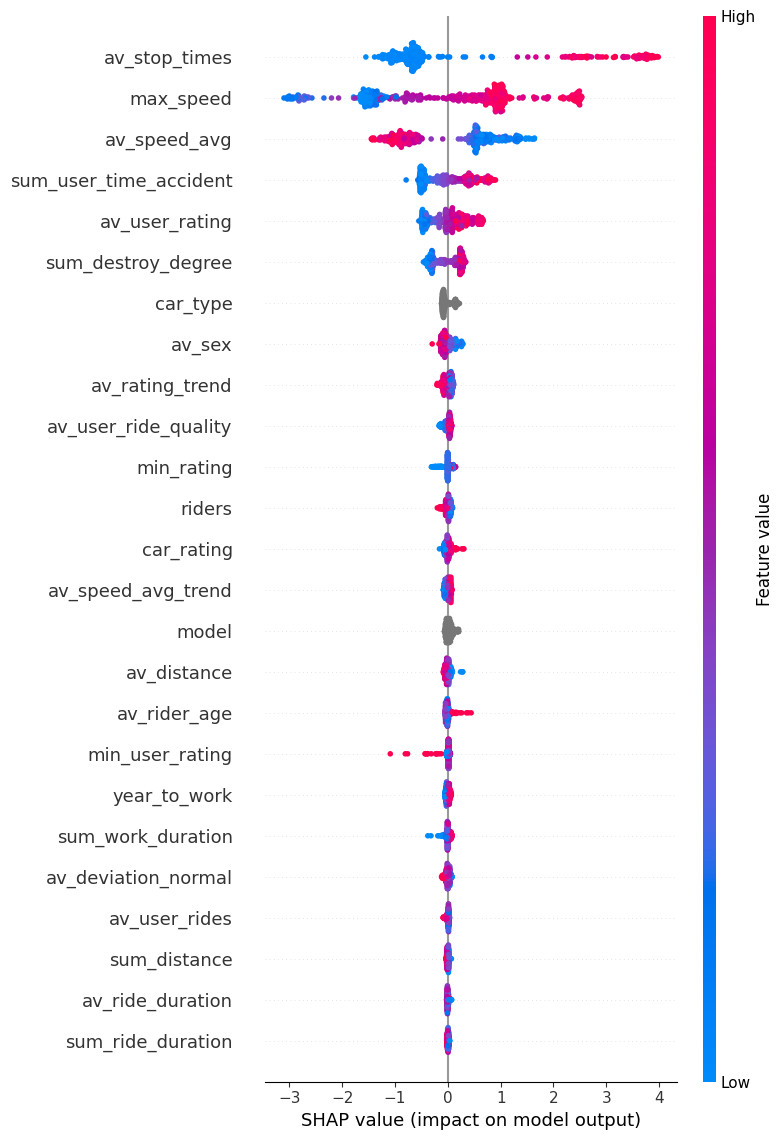

In [55]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values[:,:,0], X_test, max_display = 25)

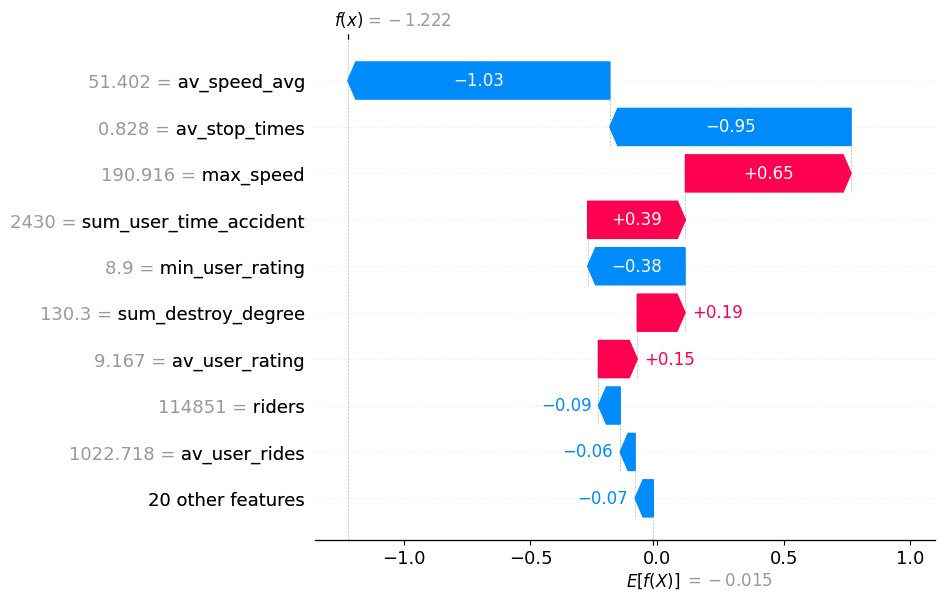

In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

shap_expl = shap.Explanation(shap_values[:,:,0], shap_values.base_values[:,0], X_test, feature_names=list(X_test))

shap.waterfall_plot(shap_expl[0])

*Низкая средняя скорость, малое число остановок и низкий минимальный рейтингдвигают выход модели к похожему результату. То же самое можно сказать про высокую максимальную скорость и высокую аварийность.*

In [57]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      0.98      0.99        49
    engine_fuel       0.97      1.00      0.98        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      0.98      0.99        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



*Хуже всего модель справляется с предсказанием wheel_shake (вероятно, из-за меньшей представленности данной поломки) и another_bug (вероятно, из-за разнородности поломок в данной группе)*

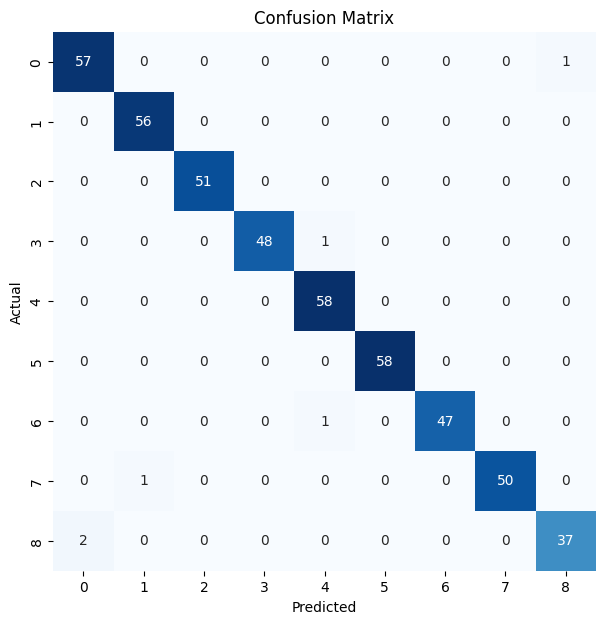

In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [63]:
print(f"Модель путает 0 и 8 классы: {val_dataset.get_label()[0]} и {val_dataset.get_label()[8]}")

Модель путает 0 и 8 классы: engine_fuel и engine_check


*Вероятно данные виды поломок похожи по параметрам*

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [43]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.0005, log=True), # скорость обучения
        'depth': trial.suggest_int('depth', 3, 10), # глубина деревьев
        'l2_leaf_reg':  trial.suggest_float('l2_leaf_reg', 1000, 10000, log=True), #  сила регуляризации для листьев деревьев
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.0, log=True), # температура распределения Больцмана для выбора объектов бутстрэп-выборки
        'border_count': trial.suggest_int('border_count', 32, 255) # количество точек разбиения для числовых признаков
    }

    model = CatBoostClassifier(**params, 
                               random_state=42, 
                               cat_features=cat_features, 
                               thread_count=-1,
                               custom_metric=['Accuracy'], 
                               early_stopping_rounds=100,
                               task_type='GPU')
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              verbose=False, 
              )
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               show_progress_bar=True 
               n_trials=10)

print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Params:", trial.params)


[I 2024-03-31 12:50:21,573] A new study created in memory with name: no-name-03e053e2-cd39-4f62-a35b-4b668564c2f6
[I 2024-03-31 12:50:50,827] Trial 0 finished with value: 0.9572649572649573 and parameters: {'learning_rate': 0.00013474990432760418, 'depth': 9, 'l2_leaf_reg': 6197.388910000763, 'bagging_temperature': 0.2374618085782219, 'border_count': 54}. Best is trial 0 with value: 0.9572649572649573.
[I 2024-03-31 12:50:58,707] Trial 1 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 0.00026607247968312076, 'depth': 4, 'l2_leaf_reg': 3960.3524958448133, 'bagging_temperature': 0.0944341696710114, 'border_count': 38}. Best is trial 0 with value: 0.9572649572649573.
[I 2024-03-31 12:51:49,739] Trial 2 finished with value: 0.9658119658119658 and parameters: {'learning_rate': 0.0001456892701992139, 'depth': 10, 'l2_leaf_reg': 1580.1682095564188, 'bagging_temperature': 0.0509586715049521, 'border_count': 208}. Best is trial 2 with value: 0.9658119658119658.
[I 2024

Best trial:
Accuracy: 0.9658119658119658
Params: {'learning_rate': 0.0001456892701992139, 'depth': 10, 'l2_leaf_reg': 1580.1682095564188, 'bagging_temperature': 0.0509586715049521, 'border_count': 208}


*Мы видим, что точность модели снизилась с 0.987 до 0.966, однако возможно она является более устойчивой к переобучению или эффективнее использует ресурсы. Проверим:*

In [ ]:
features2drop = ['target_class', 'target_reg'] # то, что надо выбросить
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['model', 'car_type', 'fuel_type',] # категориальные признаки

num_features = [i for i in list(car_train.columns) if i not in (features2drop + targets + cat_features)] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [53]:
%%time

X = car_train.drop(features2drop, axis=1)
y = car_train[targets[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

model = CatBoostClassifier(random_state=42,
                           cat_features=cat_features,
                           thread_count=-1,
                           custom_metric=['Accuracy'],
                           early_stopping_rounds=100,
                           task_type='GPU')
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)
          
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Learning rate set to 0.097372
0:	learn: 1.7836823	test: 1.7932420	best: 1.7932420 (0)	total: 11.9ms	remaining: 11.8s
100:	learn: 0.0375125	test: 0.1149276	best: 0.1149276 (100)	total: 1.04s	remaining: 9.24s
200:	learn: 0.0170792	test: 0.0999042	best: 0.0998848 (199)	total: 2.08s	remaining: 8.28s
300:	learn: 0.0108945	test: 0.0953860	best: 0.0953860 (300)	total: 3.13s	remaining: 7.28s
400:	learn: 0.0081102	test: 0.0937833	best: 0.0937088 (388)	total: 4.19s	remaining: 6.26s
500:	learn: 0.0064918	test: 0.0932407	best: 0.0932080 (496)	total: 5.16s	remaining: 5.14s
600:	learn: 0.0053486	test: 0.0931749	best: 0.0930626 (568)	total: 6.16s	remaining: 4.09s
bestTest = 0.09306262011
bestIteration = 568
Shrink model to first 569 iterations.
Accuracy: 0.9759358288770054
CPU times: total: 2.38 s
Wall time: 7.48 s


In [56]:
report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.98      0.98      0.98       235
      break_bug       0.98      0.99      0.98       216
    electro_bug       1.00      1.00      1.00       189
   engine_check       0.95      1.00      0.97       213
    engine_fuel       0.99      0.94      0.97       214
engine_ignition       0.99      0.98      0.98       212
engine_overheat       0.94      0.99      0.96       226
     gear_stick       0.99      0.96      0.97       227
    wheel_shake       0.97      0.96      0.96       138

       accuracy                           0.98      1870
      macro avg       0.98      0.98      0.98      1870
   weighted avg       0.98      0.98      0.98      1870



In [57]:
%%time

best_params = trial.params

X = car_train.drop(features2drop, axis=1)
y = car_train[targets[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

model = CatBoostClassifier(**best_params, random_state=42,
                           cat_features=cat_features,
                           thread_count=-1,
                           custom_metric=['Accuracy'],
                           early_stopping_rounds=100,
                           task_type='GPU')
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)
          
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

0:	learn: 2.1972228	test: 2.1972228	best: 2.1972228 (0)	total: 54.5ms	remaining: 54.4s
100:	learn: 2.1970408	test: 2.1970494	best: 2.1970494 (100)	total: 5.21s	remaining: 46.4s
200:	learn: 2.1968594	test: 2.1968760	best: 2.1968760 (200)	total: 10.4s	remaining: 41.2s
300:	learn: 2.1966775	test: 2.1967027	best: 2.1967027 (300)	total: 15.4s	remaining: 35.8s
400:	learn: 2.1964958	test: 2.1965293	best: 2.1965293 (400)	total: 20.4s	remaining: 30.5s
500:	learn: 2.1963142	test: 2.1963559	best: 2.1963559 (500)	total: 25.5s	remaining: 25.4s
600:	learn: 2.1961327	test: 2.1961828	best: 2.1961828 (600)	total: 30.7s	remaining: 20.4s
700:	learn: 2.1959508	test: 2.1960094	best: 2.1960094 (700)	total: 35.9s	remaining: 15.3s
800:	learn: 2.1957692	test: 2.1958360	best: 2.1958360 (800)	total: 41s	remaining: 10.2s
900:	learn: 2.1955875	test: 2.1956629	best: 2.1956629 (900)	total: 46.2s	remaining: 5.07s
999:	learn: 2.1954076	test: 2.1954911	best: 2.1954911 (999)	total: 51.3s	remaining: 0us
bestTest = 2.1954

In [58]:
report = classification_report(y_test, y_pred)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.85      1.00      0.92       235
      break_bug       0.93      0.98      0.95       216
    electro_bug       1.00      0.98      0.99       189
   engine_check       0.99      0.99      0.99       213
    engine_fuel       0.99      0.94      0.96       214
engine_ignition       0.98      0.98      0.98       212
engine_overheat       0.94      0.96      0.95       226
     gear_stick       1.00      0.93      0.96       227
    wheel_shake       1.00      0.80      0.89       138

       accuracy                           0.96      1870
      macro avg       0.96      0.95      0.95      1870
   weighted avg       0.96      0.96      0.96      1870



*К сожалению, мы не увидели ни большей устойчивости к переобучению, ни лучшей производительности. Можно сделать вывод, что catboost изначально имеет неплохие настройки и эффективно подстраивается в процессе обучения.*

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [143]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1, log=True), # скорость обучения
        'depth': trial.suggest_int('depth', 3, 10), # глубина деревьев
    }

    model = CatBoostClassifier(**params, 
                               random_state=42, 
                               cat_features=cat_cols, 
                               thread_count=-1,
                               custom_metric=['Accuracy'], 
                               early_stopping_rounds=100,
                               task_type='GPU')
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              verbose=False, 
              )
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               show_progress_bar=True,
               n_trials=30)

print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Params:", trial.params)


[I 2024-04-03 13:03:04,983] A new study created in memory with name: no-name-a44842a7-1171-4522-b11e-4e5c74534b4c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-04-03 13:03:12,038] Trial 0 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.004186649772011792, 'depth': 6}. Best is trial 0 with value: 0.9850427350427351.
[I 2024-04-03 13:03:31,798] Trial 1 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.04032239718178597, 'depth': 9}. Best is trial 1 with value: 0.9871794871794872.
[I 2024-04-03 13:03:36,556] Trial 2 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.2909930187184584, 'depth': 8}. Best is trial 1 with value: 0.9871794871794872.
[I 2024-04-03 13:03:38,327] Trial 3 finished with value: 0.9914529914529915 and parameters: {'learning_rate': 0.5261993627814805, 'depth': 3}. Best is trial 3 with value: 0.9914529914529915.
[I 2024-04-03 13:03:57,788] Trial 4 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.03171370045735838, 'depth': 9}. Best is trial 3 with value: 0.9914529914529915.
[I 2024-04-03 13:04:04,424] Trial 5 finis

In [144]:
best_params = trial.params

drop_cols = ['target_class', 'target_reg'] + summary['eliminated_features_names']
cat_cols = [f for f in ['car_type', 'fuel_type', 'model'] if f not in summary['eliminated_features_names']]

X = car_train.drop(drop_cols, axis=1)
y = car_train['target_class'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_cb = CatBoostClassifier(**best_params, 
                              random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,
                           task_type='GPU')
model_cb.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

y_pred = model_cb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
report = classification_report(y_test, y_pred)
print(report)

0:	learn: 0.7666927	test: 0.7994293	best: 0.7994293 (0)	total: 4.47ms	remaining: 4.46s
100:	learn: 0.0132134	test: 0.0483668	best: 0.0480766 (96)	total: 372ms	remaining: 3.31s
200:	learn: 0.0057044	test: 0.0412460	best: 0.0409748 (195)	total: 720ms	remaining: 2.86s
300:	learn: 0.0035735	test: 0.0395988	best: 0.0395757 (291)	total: 1.06s	remaining: 2.47s
400:	learn: 0.0025264	test: 0.0390153	best: 0.0389193 (398)	total: 1.42s	remaining: 2.13s
500:	learn: 0.0019780	test: 0.0395607	best: 0.0388864 (426)	total: 1.83s	remaining: 1.82s
bestTest = 0.03888638814
bestIteration = 426
Shrink model to first 427 iterations.
0.9935897435897436
                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      1.00      1.00        49
    engine_fuel       1.00      1.00      1.00        58
engine_ignition    

In [178]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0),
    }

    model = LGBMClassifier(**params,
                           objective="multiclass",
                           data_sample_strategy='goss',
                           random_state=42,
                           n_jobs=-1)
    model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='multi_logloss',
            categorical_feature=cat_cols,)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               show_progress_bar=True,
               n_trials=30)

print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Params:", trial.params)


[I 2024-04-04 11:58:26,713] A new study created in memory with name: no-name-ae1a3d4d-10ff-419f-a26c-e9dbebd2b67d


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightGBM] [Info] Start training from score -2.696877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [174]:
best_params = trial.params
model_lgb = LGBMClassifier(**best_params,
                        objective="multiclass",
                        data_sample_strategy='goss',
                        random_state=42,
                        n_jobs=-1)
model_lgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='multi_logloss',
        categorical_feature=cat_cols,)

y_pred = model_lgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
report = classification_report(y_test, y_pred)
print(report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2837
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.167183
[LightGBM] [Info] Start training from score -2.244892
[LightGBM] [Info] Start training from score -2.134996
[LightGBM] [Info] Start training from score -2.215039
[LightGBM] [Info] Start training from score -2.181301
[LightGBM] [Info] Start training from score -2.048362
[LightGBM] [Info] Start training from score -2.082120
[LightGBM] [Info] Start training from score -2.696877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [147]:
def objective(trial):
    params = {
        'eta': trial.suggest_float('eta', 0.001, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_boosting_rounds': trial.suggest_int('num_boosting_rounds', 10, 500),
    }
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_train)

    model_xgb = XGBClassifier(booster='dart', 
                              tree_method='gpu_hist',
                              random_state=42, 
                              n_jobs=-1,
                              verbosity=1)
    model_xgb.fit(X_train, y_encoded,
            eval_set=[(X_test, label_encoder.fit_transform(y_test))],
            eval_metric='mlogloss',
            early_stopping_rounds=100,
            verbose=100)
    y_pred = label_encoder.inverse_transform(model_xgb.predict(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               show_progress_bar=True,
               n_trials=30)

print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Params:", trial.params)


[I 2024-04-03 13:11:41,701] A new study created in memory with name: no-name-a4e0d6bf-236b-4363-9516-bc8077d2ff78


  0%|          | 0/30 [00:00<?, ?it/s]

[0]	validation_0-mlogloss:1.11077
[99]	validation_0-mlogloss:0.05346
[I 2024-04-03 13:12:13,284] Trial 0 finished with value: 0.9871794871794872 and parameters: {'eta': 0.036108328036163664, 'max_depth': 3, 'num_boosting_rounds': 387}. Best is trial 0 with value: 0.9871794871794872.
[0]	validation_0-mlogloss:1.11077
[99]	validation_0-mlogloss:0.05346
[I 2024-04-03 13:12:44,220] Trial 1 finished with value: 0.9871794871794872 and parameters: {'eta': 0.07439608506769387, 'max_depth': 10, 'num_boosting_rounds': 441}. Best is trial 0 with value: 0.9871794871794872.
[0]	validation_0-mlogloss:1.11077
[99]	validation_0-mlogloss:0.05346
[I 2024-04-03 13:13:15,435] Trial 2 finished with value: 0.9871794871794872 and parameters: {'eta': 0.3066334352818758, 'max_depth': 9, 'num_boosting_rounds': 447}. Best is trial 0 with value: 0.9871794871794872.
[0]	validation_0-mlogloss:1.11077
[99]	validation_0-mlogloss:0.05346
[I 2024-04-03 13:13:46,847] Trial 3 finished with value: 0.9871794871794872 and p

In [155]:
best_params = trial.params
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

model_xgb = XGBClassifier(**best_params,
                          booster='dart', 
                          random_state=42, 
                          n_jobs=-1)
model_xgb.fit(X_train, y_encoded,
          eval_set=[(X_test, label_encoder.fit_transform(y_test))],
          eval_metric='mlogloss',
          early_stopping_rounds=100,
          verbose=100)

y_pred = label_encoder.inverse_transform(model_xgb.predict(X_test))

report = classification_report(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print(report)

[0]	validation_0-mlogloss:2.06165


[99]	validation_0-mlogloss:0.10623
0.9871794871794872
                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.98      1.00      0.99        49
    engine_fuel       0.98      0.98      0.98        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       0.98      0.98      0.98        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



In [179]:
def objective(trial):
    params = {
        'criterion': trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        'n_estimators': trial.suggest_int('n_estimators', 10, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 13),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 300),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 300),
        'max_features': trial.suggest_int('max_features', 3, 20),
    }
    model_rf = RandomForestClassifier(random_state=42, 
                                      n_jobs=-1)
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_test)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               show_progress_bar=True,
               n_trials=300)

print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Params:", trial.params)


[I 2024-04-04 12:00:25,667] A new study created in memory with name: no-name-c63cfb6e-86b5-41c8-89a9-170bfce5df0c


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2024-04-04 12:00:25,862] Trial 0 finished with value: 0.9850427350427351 and parameters: {'criterion': 'gini', 'n_estimators': 1433, 'max_depth': 4, 'min_samples_split': 148, 'min_samples_leaf': 52, 'max_features': 19}. Best is trial 0 with value: 0.9850427350427351.
[I 2024-04-04 12:00:26,057] Trial 1 finished with value: 0.9850427350427351 and parameters: {'criterion': 'gini', 'n_estimators': 2583, 'max_depth': 6, 'min_samples_split': 25, 'min_samples_leaf': 123, 'max_features': 7}. Best is trial 0 with value: 0.9850427350427351.
[I 2024-04-04 12:00:26,248] Trial 2 finished with value: 0.9850427350427351 and parameters: {'criterion': 'log_loss', 'n_estimators': 1968, 'max_depth': 10, 'min_samples_split': 56, 'min_samples_leaf': 153, 'max_features': 13}. Best is trial 0 with value: 0.9850427350427351.
[I 2024-04-04 12:00:26,481] Trial 3 finished with value: 0.9850427350427351 and parameters: {'criterion': 'entropy', 'n_estimators': 1330, 'max_depth': 11, 'min_samples_split': 295, '

In [176]:
# Поскольку optuna не дала прироста метрик, оставляем модель с предустановленными параметрами
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

report = classification_report(y_test, y_pred)
print('Accuracy:', trial.value)
print(report)

Accuracy: 0.9850427350427351
                 precision    recall  f1-score   support

    another_bug       0.95      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      0.98      0.99        49
    engine_fuel       0.97      0.98      0.97        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       0.98      0.98      0.98        48
     gear_stick       1.00      0.98      0.99        51
    wheel_shake       0.97      0.92      0.95        39

       accuracy                           0.98       468
      macro avg       0.98      0.98      0.98       468
   weighted avg       0.98      0.98      0.98       468



In [221]:
# Блендинг

data_to_predict = X_test

predictions_cb = model_cb.predict(data_to_predict).reshape(-1)
predictions_lgb = model_lgb.predict(data_to_predict).reshape(-1)
predictions_xgb = label_encoder.inverse_transform(model_xgb.predict(data_to_predict)).reshape(-1)
predictions_rf = model_rf.predict(data_to_predict)

predictions_all = {'predictions_cb': predictions_cb, 'predictions_lgb': predictions_lgb, 'predictions_xgb': predictions_xgb, 'predictions_rf': predictions_rf}

# `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
df_hard_voting = pd.DataFrame(predictions_all)
df_hard_voting['prediction_ensembled'] = df_hard_voting.mode(axis=1)[0]

# `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
weights = {'predictions_cb': 0.5, 'predictions_lgb': 0.2, 'predictions_xgb': 0.2, 'predictions_rf': 0.1}

prediction_ensembled = []
temp_list = []
for i in range(len(data_to_predict)):
    for key in weights.keys():
        for j in range(int(weights[key] * 10)):
            temp_list.append(predictions_all[key][i])
    prediction_ensembled.append(mode(temp_list))
    temp_list.clear()
predictions_all['prediction_ensembled'] = prediction_ensembled

df_soft_voting = pd.DataFrame(predictions_all)


In [220]:
df_soft_voting

,predictions_cb,predictions_lgb,predictions_xgb,predictions_rf,prediction_ensembled
0,engine_fuel,engine_fuel,engine_overheat,engine_overheat,engine_fuel
1,electro_bug,electro_bug,electro_bug,electro_bug,electro_bug
2,engine_overheat,engine_overheat,engine_overheat,engine_overheat,engine_overheat
3,engine_ignition,engine_ignition,engine_ignition,engine_ignition,engine_ignition
4,engine_ignition,engine_ignition,engine_ignition,engine_ignition,engine_ignition
...,...,...,...,...,...
463,another_bug,another_bug,another_bug,another_bug,another_bug
464,engine_overheat,engine_overheat,engine_overheat,engine_overheat,engine_overheat
465,gear_stick,gear_stick,gear_stick,gear_stick,gear_stick
466,engine_fuel,engine_fuel,engine_fuel,engine_fuel,engine_fuel


In [227]:
# Метрики точности по hard_voting
y_pred = np.array(df_hard_voting['prediction_ensembled'])
report = classification_report(y_test, y_pred)
print('hard voting accuracy:', accuracy_score(y_test, y_pred))
print(report)

hard voting accuracy: 0.9871794871794872
                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       0.98      1.00      0.99        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.98      1.00      0.99        49
    engine_fuel       0.98      1.00      0.99        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      0.98      0.99        48
     gear_stick       1.00      0.96      0.98        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



In [228]:
y_pred = np.array(df_soft_voting['prediction_ensembled'])
report = classification_report(y_test, y_pred)
print('soft voting accuracy:', accuracy_score(y_test, y_pred))
print(report)

soft voting accuracy: 0.9935897435897436
                 precision    recall  f1-score   support

    another_bug       0.97      0.98      0.97        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      1.00      1.00        49
    engine_fuel       1.00      1.00      1.00        58
engine_ignition       1.00      1.00      1.00        58
engine_overheat       1.00      1.00      1.00        48
     gear_stick       1.00      1.00      1.00        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



*В нашем случае soft voting показал результат аналогичный моно catboost, в этом случае не имеет смысл оставлять блендинг, лучше использовать соло-модель. Hard voting показал результат хуже, поскольку одна из моделей превосходит остальные по точности.
Но в общем и целом на наших данных все модели справились отлично.*

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [248]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [249]:
car_test.shape

(1913, 8)

In [250]:
car_test = car_test.merge(rides_info_gp[['car_id',
       'min_rating', 'av_rating_trend', 'av_ride_duration',
       'sum_ride_duration', 'av_speed_avg', 'av_speed_avg_trend', 'max_speed',
       'av_stop_times', 'av_distance', 'sum_distance',
       'av_user_ride_quality', 'av_deviation_normal']], on='car_id', how='left')
car_test.shape

(1913, 20)

In [251]:
car_test = car_test.merge(driver_info_gp, on='car_id', how='left')
car_test.shape

(1913, 27)

In [252]:
car_test = car_test.merge(fix_info_gp, on='car_id', how='left')
car_test.shape

(1913, 30)

In [253]:
drop_cols = ['car_id'] + summary['eliminated_features_names']
X_test_to_kaggle = car_test.drop(drop_cols, axis=1)
y_pred_to_kaggle = model_cb.predict(X_test_to_kaggle)

In [261]:
car_test['target_class'] = y_pred_to_kaggle.reshape(-1)

In [266]:
car_test[['car_id', 'target_class']].to_csv('predictions.csv', index=False)

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.